# Imports & Load

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# For live reloading during development
import importlib

from src.pricing_api import (
    price_option,
    simulate_jump_paths,
    generate_smile,
    compare_with_black_scholes,
)
from src.plotting import (
    plot_price_surface,
    plot_paths,
)

# Reload modules when editting src/ while working
import src.pide_solver
import src.pide_operator
import src.integral_terms
import src.jump_models
import src.simulation
import src.plotting
import src.pricing_api

for m in [
    src.jump_models,
    src.integral_terms,
    src.pide_operator,
    src.pide_solver,
    src.simulation,
    src.plotting,
    src.pricing_api,
]:
    importlib.reload(m)

print("Modules reloaded.")

Modules reloaded.


# Input parameters

Here we mannually define all “market” and “model” inputs that will be shared across sections. They are all customisable in this notebook: no CSV, no config files.

In [20]:
# TO BE CUSTOMIZED DEPENDING ON THE SCENARIO TO TEST

# Market inputs
S0 = 100.0    # spot
r = 0.02      # risk-free rate
q = 0.00      # continuous dividend yield
T = 1.0       # maturity in years

# Diffusion volatility (baseline)
sigma_bs = 0.2

# ATM strike used in the benchmark pricing sections
K_atm = 100.0

# Jump parameters (Merton)
lam_merton = 1.0      # jump intensity λ
mu_J_merton = -0.1    # mean of log-jump Y
sigma_J_merton = 0.2  # std of log-jump Y

# Jump parameters (Kou)
lam_kou = 1.0
p_kou = 0.4
eta1_kou = 10.0
eta2_kou = 5.0

# PIDE grid parameters
S_min = 20.0
S_max = 300.0
NS = 200      # number of S points
NT = 200      # number of time steps
theta = 0.5   # Crank–Nicolson

y_min = -1.0  # jump size truncation range in log-space
y_max = 1.0
Ny = 201

# Helper dict for PIDE grid parameters
grid_kwargs = dict(
    S_min=S_min,
    S_max=S_max,
    NS=NS,
    NT=NT,
    theta=theta,
    y_min=y_min,
    y_max=y_max,
    Ny=Ny,
)

print("Global parameters set.")

Global parameters set.


# Output 1 : Prices (European Call) & Surface Plot (BS vs Merton vs Kou) 

[BS] Price = 8.7044
[Merton] Price = 11.9568
[Kou] Price = 11.7964


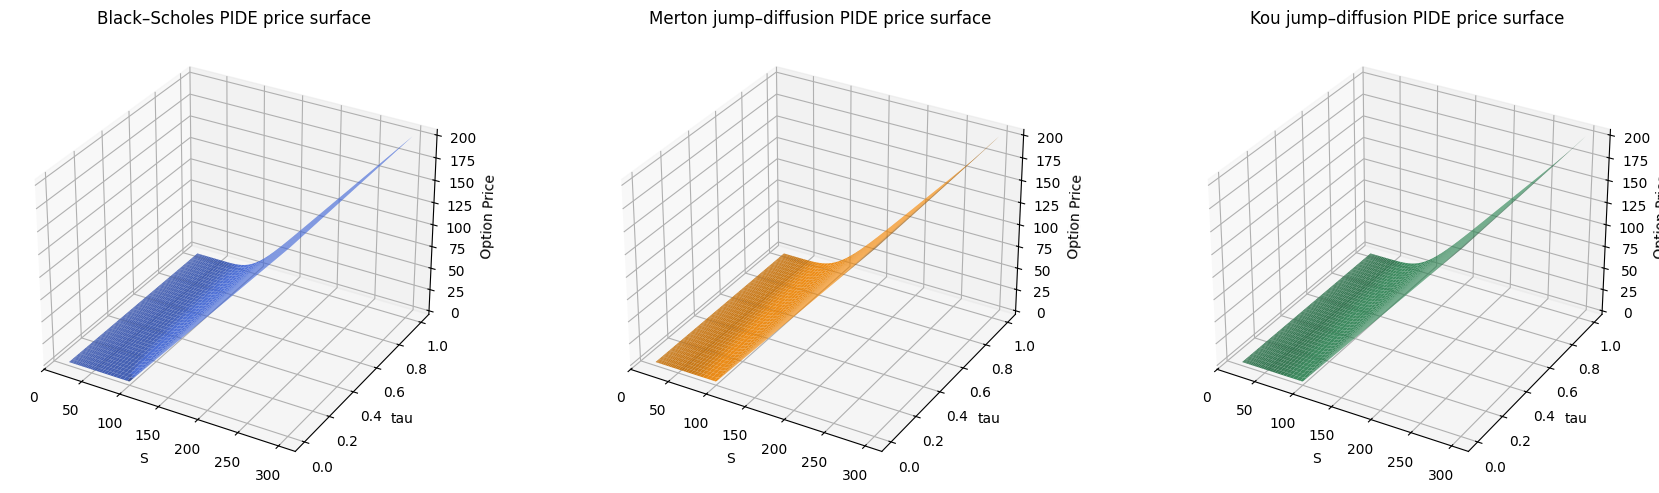

In [34]:
fig = plt.figure(figsize=(18, 5))

# Black–Scholes
res_bs = price_option(
    model="BlackScholes",
    S0=S0,
    K=K_atm,
    T=T,
    r=r,
    q=q,
    sigma=sigma_bs,
    lam=0.0,
    **grid_kwargs,
)

print(f"[BS] Price = {res_bs['price_S0']:.4f}")

ax1 = fig.add_subplot(131, projection="3d")
Tau1, S1 = np.meshgrid(res_bs["tau_grid"], res_bs["S_grid"], indexing="ij")
surf1 = ax1.plot_surface(S1, Tau1, res_bs["U"], color="royalblue", alpha=0.9)
ax1.set_title("Black–Scholes PIDE price surface")
ax1.set_xlabel("S"); ax1.set_ylabel("tau"); ax1.set_zlabel("Option Price")

# Merton
res_merton = price_option(
    model="Merton",
    S0=S0,
    K=K_atm,
    T=T,
    r=r,
    q=q,
    sigma=sigma_bs,
    lam=lam_merton,
    mu_J=mu_J_merton,
    sigma_J=sigma_J_merton,
    **grid_kwargs,
)

print(f"[Merton] Price = {res_merton['price_S0']:.4f}")

ax2 = fig.add_subplot(132, projection="3d")
Tau2, S2 = np.meshgrid(res_merton["tau_grid"], res_merton["S_grid"], indexing="ij")
surf2 = ax2.plot_surface(S2, Tau2, res_merton["U"], color="darkorange", alpha=0.9)
ax2.set_title("Merton jump–diffusion PIDE price surface")
ax2.set_xlabel("S"); ax2.set_ylabel("tau"); ax2.set_zlabel("Option Price")

# Kou
res_kou = price_option(
    model="Kou",
    S0=S0,
    K=K_atm,
    T=T,
    r=r,
    q=q,
    sigma=sigma_bs,
    lam=lam_kou,
    p=p_kou,
    eta1=eta1_kou,
    eta2=eta2_kou,
    **grid_kwargs,
)

print(f"[Kou] Price = {res_kou['price_S0']:.4f}")

ax3 = fig.add_subplot(133, projection="3d")
Tau3, S3 = np.meshgrid(res_kou["tau_grid"], res_kou["S_grid"], indexing="ij")
surf3 = ax3.plot_surface(S3, Tau3, res_kou["U"], color="seagreen", alpha=0.9)
ax3.set_title("Kou jump–diffusion PIDE price surface")
ax3.set_xlabel("S"); ax3.set_ylabel("tau"); ax3.set_zlabel("Option Price")

plt.tight_layout()
plt.show()

# Ouput 2 : Implied volatility Smiles Plot (BS vs Merton vs Kou)

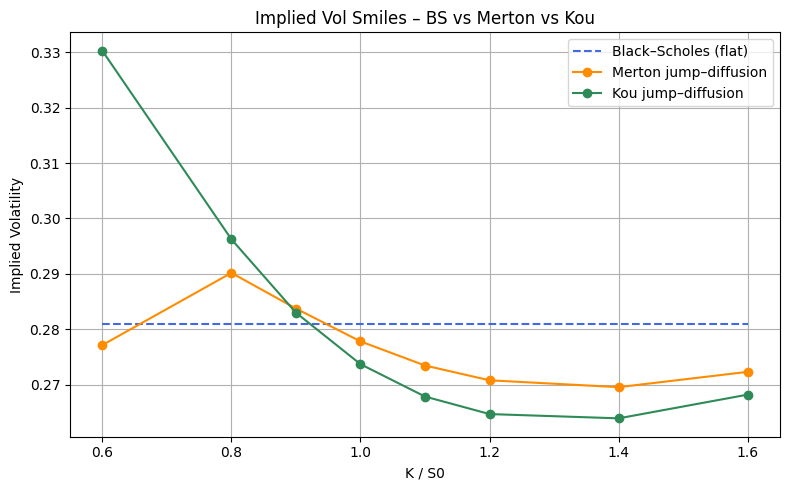

In [ ]:
strikes = np.array([60, 80, 90, 100, 110, 120, 140, 160], dtype=float)

# Generate smiles
smile_merton = generate_smile(
    model="Merton",
    S0=S0,
    strikes=strikes,
    T=T,
    r=r,
    q=q,
    sigma=sigma_bs,
    lam=lam_merton,
    mu_J=mu_J_merton,
    sigma_J=sigma_J_merton,
    grid_kwargs=grid_kwargs,
    plot=True,
)
plt.close()

smile_kou = generate_smile(
    model="Kou",
    S0=S0,
    strikes=strikes,
    T=T,
    r=r,
    q=q,
    sigma=sigma_bs,
    lam=lam_kou,
    p=p_kou,
    eta1=eta1_kou,
    eta2=eta2_kou,
    grid_kwargs=grid_kwargs,
    plot=True,
)
plt.close()

# Extract vols
moneyness = strikes / S0
iv_merton = smile_merton["ivols"]
iv_kou    = smile_kou["ivols"]
sigma_ref = float(np.mean(iv_kou))  
iv_bs = np.full_like(strikes, sigma_ref)

# Figure
plt.figure(figsize=(8, 5))

plt.plot(moneyness, iv_bs, "--", color="royalblue", label="Black–Scholes (flat)")
plt.plot(moneyness, iv_merton, "o-", color="darkorange", label="Merton jump–diffusion")
plt.plot(moneyness, iv_kou, "o-", color="seagreen", label="Kou jump–diffusion")

plt.title("Implied Vol Smiles – BS vs Merton vs Kou")
plt.xlabel("K / S0")
plt.ylabel("Implied Volatility")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Output 3 : Jump–diffusion path simulation (Merton and Kou)

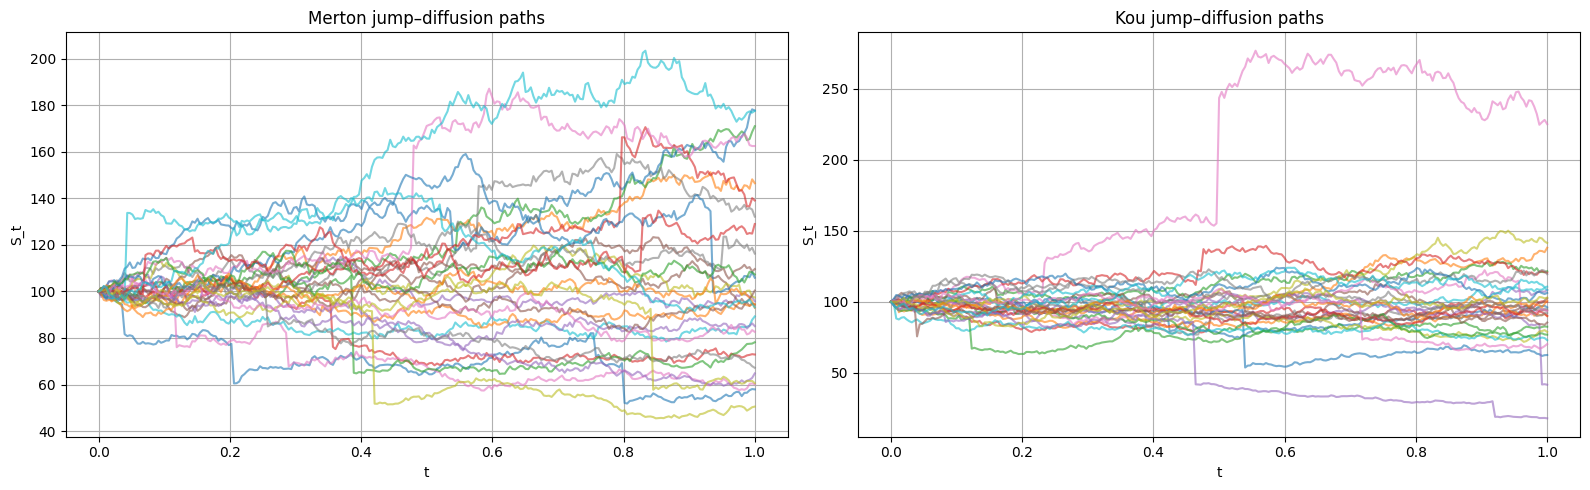

In [ ]:
# View simulated paths
n_paths = 200
n_steps = 252

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Merton
sim_merton = simulate_jump_paths(
    model="Merton",
    S0=S0,
    T=T,
    r=r,
    q=q,
    sigma=sigma_bs,
    lam=lam_merton,
    mu_J=mu_J_merton,
    sigma_J=sigma_J_merton,
    n_paths=n_paths,
    n_steps=n_steps,
    seed=42,
)

axes[0].plot(sim_merton["t_grid"], sim_merton["paths"][:30].T, alpha=0.6)
axes[0].set_title("Merton jump–diffusion paths")
axes[0].set_xlabel("t")
axes[0].set_ylabel("S_t")
axes[0].grid(True)

# Kou
sim_kou = simulate_jump_paths(
    model="Kou",
    S0=S0,
    T=T,
    r=r,
    q=q,
    sigma=sigma_bs,
    lam=lam_kou,
    p=p_kou,
    eta1=eta1_kou,
    eta2=eta2_kou,
    n_paths=n_paths,
    n_steps=n_steps,
    seed=43,
)

axes[1].plot(sim_kou["t_grid"], sim_kou["paths"][:30].T, alpha=0.6)
axes[1].set_title("Kou jump–diffusion paths")
axes[1].set_xlabel("t")
axes[1].set_ylabel("S_t")
axes[1].grid(True)

plt.tight_layout()
plt.show()

# Output 4 :  Model prices comparison table for several strikes and maturities (BS vs Merton vs Kou)

In [ ]:
# Choice a small grid of maturities and strikes
maturities = [0.25, 0.5, 1.0, 2.0]   # in years
strikes_grid = [60, 80, 100, 120, 140]

rows = []

for T_cmp in maturities:
    for K_cmp in strikes_grid:
        # Black–Scholes (no jumps)
        res_bs_cmp = price_option(
            model="BlackScholes",
            S0=S0,
            K=K_cmp,
            T=T_cmp,
            r=r,
            q=q,
            sigma=sigma_bs,
            lam=0.0,
            **grid_kwargs,
        )
        price_bs = res_bs_cmp["price_S0"]

        # Merton
        res_merton_cmp = price_option(
            model="Merton",
            S0=S0,
            K=K_cmp,
            T=T_cmp,
            r=r,
            q=q,
            sigma=sigma_bs,
            lam=lam_merton,
            mu_J=mu_J_merton,
            sigma_J=sigma_J_merton,
            **grid_kwargs,
        )
        price_merton = res_merton_cmp["price_S0"]

        # Kou
        res_kou_cmp = price_option(
            model="Kou",
            S0=S0,
            K=K_cmp,
            T=T_cmp,
            r=r,
            q=q,
            sigma=sigma_bs,
            lam=lam_kou,
            p=p_kou,
            eta1=eta1_kou,
            eta2=eta2_kou,
            **grid_kwargs,
        )
        price_kou = res_kou_cmp["price_S0"]

        rows.append(
            dict(
                T=T_cmp,
                K=K_cmp,
                Price_BS=price_bs,
                Price_Merton=price_merton,
                Price_Kou=price_kou,
            )
        )

df_cmp = pd.DataFrame(rows)
df_cmp = df_cmp.sort_values(by=["T", "K"]).reset_index(drop=True)

pd.set_option("display.float_format", lambda x: f"{x:0.4f}")
df_cmp

,T,K,Price_BS,Price_Merton,Price_Kou
0,0.2500,60,39.9340,39.9943,40.1138
1,0.2500,80,20.0726,20.7491,20.7909
2,0.2500,100,4.0355,5.3180,5.1640
3,0.2500,120,0.1539,0.5794,0.5349
4,0.2500,140,0.0013,0.0996,0.1005
5,0.5000,60,40.2321,40.4203,40.6323
6,0.5000,80,20.7071,22.0023,22.0767
7,0.5000,100,5.9177,8.0267,7.8329
8,0.5000,120,0.7878,1.9145,1.7895
9,0.5000,140,0.0554,0.4244,0.3962
